# Martingale Betting Strategy

The Martingale system is a classical loss-recovery betting method in which the stake is doubled after each loss and reset to the base stake after each win. This notebook examines the behaviour of the Martingale strategy using both a single-path simulation and a Monte Carlo analysis.

### Key Characteristics
- The stake increases exponentially during losing streaks.
- A single extended losing sequence can quickly exhaust the bankroll.
- Under negative expected value (roulette for example), the strategy produces many small gains and occasional large losses.
- The distribution of outcomes tends to be highly skewed.

The implementation used here is defined in the project's martingale.py module.

In [13]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from ..rng import roulette_like_trial
from ..strategies.martingale import martingale_bettor
from ..runner import run_simulation

plt.style.use("seaborn-v0_8-darkgrid")
random.seed(42)

## 1. Simulation Parameters

The following parameters will be used for both the single-path and Monte Carlo simulations.

In [14]:
initial_funds = 10_000
stake = 100
n_rounds = 100
p_win = 0.49

## 2. Single Bettor Path

A single bettor is simulated to illustrate how the Martingale strategy evolves over time. The seed is reset to ensure the result is fully deterministic.

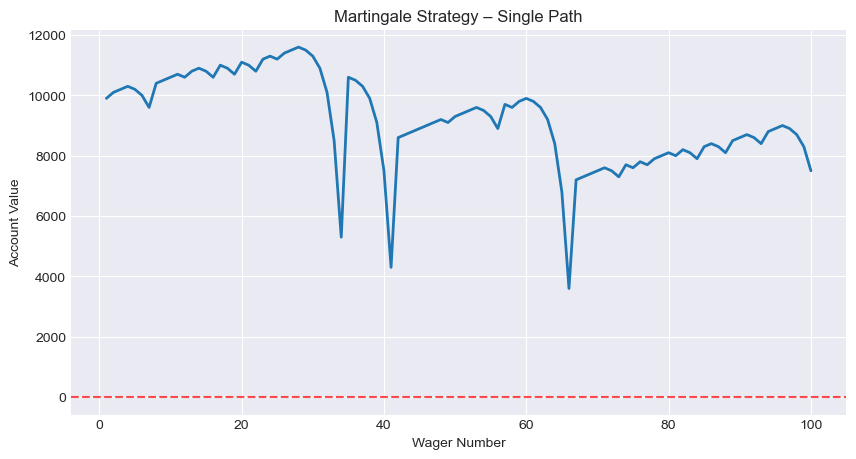

In [15]:
random.seed(42)

def trial():
    return roulette_like_trial(p_win)

wagers, values = martingale_bettor(
    initial_funds=initial_funds,
    initial_stake=stake,
    n_rounds=n_rounds,
    rng_fn=trial
)

plt.figure(figsize=(10,5))
plt.plot(wagers, values, linewidth=2)
plt.axhline(0, color="red", linestyle="--", alpha=0.7)
plt.xlabel("Wager Number")
plt.ylabel("Account Value")
plt.title("Martingale Strategy – Single Path")
plt.show()

- The exponential losses are clear on the plot; in this case no losing streak resulted in ruin.
- At several points, a single additional loss would have been fatal.
- Winning streaks progress with a constant gradient, as expected, since the stake reverts to the initial value after each win.

## 3. Monte Carlo Simulation Over Many Bettors

A Monte Carlo analysis is performed over many independent bettors to examine the distribution of final bankroll values and the likelihood of ruin.


In [16]:
n_bettors = 500

final_values, broke_count = run_simulation(
    martingale_bettor,
    initial_funds,
    stake,
    n_rounds,
    n_bettors,
    p_win=p_win,
    seed=42
)

print("Bettors who went broke: " + str(broke_count))
print("Broke rate: " + str(round(broke_count / n_bettors * 100, 2)) + " %")

mean_value = np.mean(final_values)
median_value = np.median(final_values)

print("Mean final wealth: " + str(round(mean_value, 2)))
print("Median final wealth: " + str(round(median_value, 2)))

Bettors who went broke: 150
Broke rate: 30.0 %
Mean final wealth: 9466.8
Median final wealth: 14100.0


## 4. Histogram of Final Wealth

A histogram illustrates the distribution of final bankrolls from the Monte Carlo experiment.

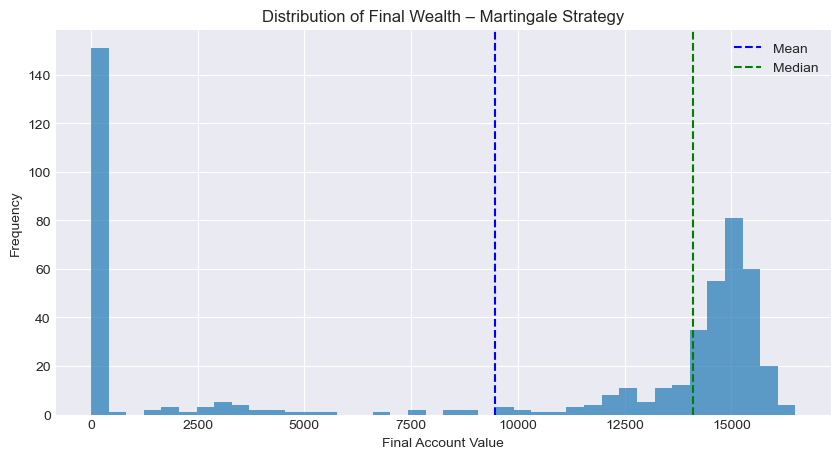

In [17]:
plt.figure(figsize=(10,5))
plt.hist(final_values, bins=40, alpha=0.7)
plt.axvline(mean_value, color="blue", linestyle="--", label="Mean")
plt.axvline(median_value, color="green", linestyle="--", label="Median")
plt.title("Distribution of Final Wealth – Martingale Strategy")
plt.xlabel("Final Account Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

- The histogram illustrates a key property of the Martingale strategy: a positive median return. 
- Most bettors realise modest gains, while a significant fraction experience complete ruin. 

Although the median outcome is positive, the probability of bankruptcy is substantially higher 
than under a simple (flat) betting strategy. The expected value of the game remains negative, 
as reflected in the mean final wealth, which lies below the initial bankroll.

## Summary

- The Martingale strategy doubles the stake after each loss, producing rapid capital escalation during losing streaks.
- Most simulated paths show modest gains, but rare, extended losing sequences lead to large losses and ruin.
- The Monte Carlo simulation highlights the skewed distribution of final outcomes.
- Under a game with a slight house edge, the long-term expectation remains negative.
